In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler

# Basic NLP for forecasting

Finally, the text is ready to be modeled. However, this notebook is relatively short, and that is for a few reasons. First, the classification process in general was dubious at best. I took text, which may or may not be related to changes in gas or oil prices, and then labeled them with changes in gas prices, which may or may not have anything to do with anything that was reported on that week. To do anything more than that would require a great deal of work, and as the NLP components were purely supplemental for this project, I had to spend time elsewhere. Therefore, low accuracy is to be expected.

The second reason is that most models I tried didn't really differ much from one another. The would have different confusion matrices, but due to the ternary classing and low accuracy in general, it became very hard to say that one model was *quantitatively* better than another. 

As such, only two major things are done in this notebook: a custom scoring function is defined, and a "good enough" model is fitted (with default parameters). All that said, I would have liked to have done more with NLP, but it just wasn't possible with time constraints.

In [16]:
# load in the data
corpus_full = pd.read_csv("../data/corpus.csv").set_index("date")

corpus = corpus_full.loc[:"2019-01-01"]

# define features in two groups
language_features = ["text_cleaned", "title_cleaned"]
supplemental_features = ["is_opec", "is_brent", "is_wti"]

X = corpus[language_features + supplemental_features]

X_full = corpus_full[language_features + supplemental_features]

# ternary classification is used
y = corpus["ternary"]

(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, stratify=y, random_state=42)

# the data is resampled so that the minority classes are more heavily weighted
ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

The basic logic for the pipeline is that the data is split into the title, text, and supplementary features. The title and text are both fitted on their own random forest after being vectorized. The supplemental features are "passed through" the first layer of the StackingClassifier, which the class and function below allow for.

In [4]:
class MultiPassthrough(BaseEstimator):
    # estimator object which does nothing
    def fit(self, X, y):
        return self

    # when predict is called, all of the inputs are returned
    def predict(self, X):
        return X

# transformer which returns the input
identity = FunctionTransformer(lambda x: x)

The one thing that did seem to significantly increase performance was to implement a custom scoring function, defined below. The formula is as follows:

$$
    S = \sum\left[ (|y_t| + |y_p|)\frac{y_t y_p - 1}{y_t y_p + 1 + \epsilon} - 10 \frac{|y_p - y_t|}{|y_t| + \epsilon}\right] \leq 0
$$

This seems like something of a strange score, but it can be summed up quite simply: if a neutral label is guessed (0), a small penalty is issued. If a positive label is guessed ($\pm 1$), a large penalty is issued. If the label guessed is correct, no penalty is issued. Higher scores are better, with a maximum score of zero being possible.

In [2]:
def custom_scorer(y_true, y_pred, **kwargs):
    eps = 1e-3
    s = np.sum(
        (np.abs(y_true) + np.abs(y_pred))
        * (y_true * y_pred - 1)
        / (1 + y_true * y_pred + eps)
        - (10 * abs(y_pred - y_true)) / (abs(y_true) + eps)
    )

    return s

Below, the model is defined as a stacking classifier that has three pipelines for the text, title, and supplemental feature. The GridSearchCV class is used to make use of custom scoring, but the params dictionary is currently empty as most paramters did not create significant changes. Thus, it is empty for the sake of time during rerunning.

In [5]:
cv = CountVectorizer()
tfidf = TfidfVectorizer()

rfc = RandomForestClassifier()
logr = LogisticRegression()

mpt = MultiPassthrough()
scorer = make_scorer(custom_scorer)

title_pipe = Pipeline(
    [
        (
            "vectorizer",
            ColumnTransformer([("vectorizer", cv, "title_cleaned")]),
        ),  # the estimators are declared with initial vectorizers and models
        ("model", rfc),  # but these will be replaced by the param dictionaries
    ]
)

article_pipe = Pipeline(
    [
        ("vectorizer", ColumnTransformer([("vectorizer", cv, "text_cleaned")])),
        ("model", rfc),
    ]
)

supplemental_pipe = Pipeline(
    [
        (
            "transformer",
            ColumnTransformer([("transformer", identity, supplemental_features)]),
        ),
        ("passthrough", mpt),
    ]
)

estimators = [
    ("title_pipe", title_pipe),
    ("article_pipe", article_pipe),
    ("supplemental_pipe", supplemental_pipe),
]

final_estimator = logr

model = StackingClassifier(
    estimators=estimators, final_estimator=final_estimator, n_jobs=-1
)

params = {}

gs = GridSearchCV(model, params, n_jobs=-1, verbose=1, scoring=scorer)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(estimator=StackingClassifier(estimators=[('title_pipe',
                                                       Pipeline(steps=[('vectorizer',
                                                                        ColumnTransformer(transformers=[('vectorizer',
                                                                                                         CountVectorizer(),
                                                                                                         'title_cleaned')])),
                                                                       ('model',
                                                                        RandomForestClassifier())])),
                                                      ('article_pipe',
                                                       Pipeline(steps=[('vectorizer',
                                                                        ColumnTransformer(transformers=[('vectorizer',
                                                                                                         CountVectorizer(),
                                                                                                         'text_cleaned')])),
                                                                       (...
                                                      ('supplemental_pipe',
                                                       Pipeline(steps=[('transformer',
                                                                        ColumnTransformer(transformers=[('transformer',
                                                                                                         FunctionTransformer(func=<function <lambda> at 0x7fbeaeeb9630>),
                                                                                                         ['is_opec',
                                                                                                          'is_brent',
                                                                                                          'is_wti'])])),
                                                                       ('passthrough',
                                                                        MultiPassthrough())]))],
                                          final_estimator=LogisticRegression(),
                                          n_jobs=-1),
             n_jobs=-1, param_grid={}, scoring=make_scorer(custom_scorer),
             verbose=1)

Below, the confusion matrix for the model is displayed. As intended, the model overwhelmingly chooses the neutral label, and *most* of the positive labels are correct. However, the NLP model has not been rigorously defined and tested. Moving forward, this is one of the first areas that I intend to make improvements.

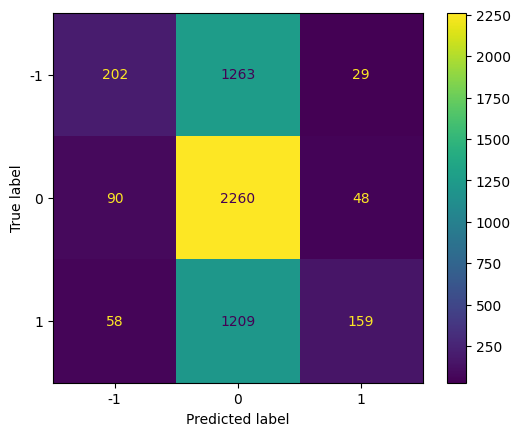

In [7]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test)

In [17]:
nlp_labels = gs.predict(X_full)

array([0, 0, 0, ..., 0, 0, 0])

The labels for whether the NLP predicts if gas price will increase or decrease in the next week are then assigned to date labels and written to a file.

In [21]:
nlp_processed = pd.DataFrame(nlp_labels, columns=["nlp_label"])
nlp_processed["date"] = corpus_full.index

nlp_predictions = nlp_processed.groupby("date").mean().reset_index()
nlp_predictions = nlp_predictions.set_index("date")

In [22]:
nlp_predictions.to_csv("../data/nlp_predictions.csv")